<a href="https://colab.research.google.com/github/RERobbins/data_science_266_sandbox/blob/main/Embeddings_and_Vector_Databases.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

## OpenAI and Cohere Accounts and API Endpoints

OpenAI and Cohere provide large language models.  This notebook uses API endpoints from each.  

OpenAI provides free, rate-limited usage to its API endpoint for a three-month trial period.  In order to use the OpenAI API endpoint you will need an OpenAI API token.

Cohere provides free, rate-limited usage for learning and prototyping. In order to use Cohere you will need a Cohere API token.

If you don't already have an OpenAI API token you can get one by signing up for a free OpenAI account from the [OpenAI Signup page](https://platform.openai.com/signup?launch).  Once you have created your OpenAI account you can create a trial API key from the [OpenAI API page](https://platform.openai.com/account/api-keys).

If you don't already have a Cohere API token you can get one by signing up for a Cohere account from the [Cohere dashboard](https://dashboard.cohere.ai).  Once you have created your Cohere account you can create a trial API key from the [Cohere API Keys page](https://dashboard.cohere.ai/api-keys).

## Mount Google Drive

By default, the data you create in Google Colaboratory does not persist from session to session.  Each session runs in a virtual machine and when that machine goes away, so does your data.  If you want your data to persist, you must store it outside the virtual machine. Google Drive can be used for that purpose.  We use it later in this notebook to store the OpenAI and Cohere API keys.

In [364]:
from google.colab import drive
drive.mount('drive')

Drive already mounted at drive; to attempt to forcibly remount, call drive.mount("drive", force_remount=True).


## Python-dotenv

`Python-dotenv` is a Python module that allows you to specify environment variables in traditional UNIX-like “.env” (dot-env) file within your Python project directory.

Environment variables are key-value pairs for the current user environment. They are generally set by the operating system and the current user-specific configurations.

`Python-dotenv` allows the user to work with API keys without exposing them to the outside world.

In [365]:
!pip install --quiet python-dotenv

## Add API Keys to .env File

The format of a .env file is simple: each line contains a single key-value pair, with the key and value separated by an equal sign (=). Here's an example:
```
DATABASE_URL=your_database_url
API_KEY=your_api_key
DEBUG=True
```
To use OpenAI and Cohere, we need to set the `OPENAI_API_KEY` and `COHERE_API_KEY` environment variables, which means the `.env` file should have lines that looks like:
```
OPENAI_API_KEY=your_openai_api_key_value
COHERE_API_KEY=your_cohere_api_key_value
```
One way to do that is to create or edit the `.env` file directly.  As with most Unix systems, file names that begin with a `.` in Google Drive are hidden from display, but you can still access them. For example, if you enter the name `.env` in the Google Drive search bar, you will be able to access your `.env` file (if it exists).

You can use the `append_key_to_env` helper function included below.  If used without arguments it will prompt the user for the value of an OpenAI API key and then the value of a Cohere API key and append each with the correct key name to the `.env` file in the root of the users Google Drive folder.  It will create the `.env` file if necessary.  You can provide an alternate list of key names and an alternate path to the function if you desire, but the defaults are fine for this notebook.

Once the OpenAI and Cohere APIs key have been stored in the `.env` file you should not need to do anything else with that file.  If either of your keys change you will need to update the `.env` file.

In [366]:
def append_key_to_env (env_file_path = '/content/drive/MyDrive/.env',
                           key_names = ['OPENAI_API_KEY', 'COHERE_API_KEY']):
  import getpass
  with open(env_file_path, 'a') as env_file:
    for key_name in key_names:
      key_value = getpass.getpass (f"Please enter the value for {key_name}: ")
      env_file.write(f'{key_name}={key_value}\n')

In [367]:
# Remove the # character in the line below and run if desired
# append_key_to_env()

## Load the API Keys

The following cell loads the OpenAI and Cohere API keys into the current environment.

In [368]:
import os
from dotenv import load_dotenv, find_dotenv

load_dotenv('/content/drive/MyDrive/.env')
OPENAI_API_KEY = os.environ["OPENAI_API_KEY"]
COHERE_API_KEY = os.environ["COHERE_API_KEY"]

# Langchain

LangChain is a framework designed to simplify the creation of applications using large language models. As a language model integration framework, LangChain's use-cases largely overlap with those of language models in general, including document analysis and summarization, chatbots, and code analysis.

The examples in this notebook often use LangChain rather than the underlying Python modules.  However, when the LangChain abstraction obscures underlying elements of interest, we use the relevant Python module directly. A description of LangChain is beyond the scope of this notebook.

In [401]:
!pip install --quiet langchain

# Embeddings

We will use OpenAI and Cohere large language models.

We will use embedding models from OpenAI and Cohere as well as an embedding model from the SentenceTransformers framework.

An overview of OpenAI models can be found [here](https://platform.openai.com/docs/models/overview) and an overciew of OpenAI embeddings can be found [here](https://platform.openai.com/docs/guides/embeddings/what-are-embeddings).

An overview of Cohere models and embeddings can be found [here](https://docs.cohere.com/docs/models).

An overview of SentenceTransformers can be found [here](https://sbert.bet).  SentenceTransformers was created by Nils Reimers.  Nils is now the Director of Machine Learning at Cohere.

In [402]:
!pip install --quiet openai cohere tiktoken transformers sentence_transformers

import seaborn as sns
import matplotlib.pyplot as plt

import openai, tiktoken
from langchain.embeddings.openai import OpenAIEmbeddings
from langchain.embeddings.cohere import CohereEmbeddings

import cohere
from langchain.chat_models import ChatOpenAI
from langchain.llms import Cohere

from langchain.embeddings import HuggingFaceEmbeddings
from transformers import AutoTokenizer

from sklearn.metrics.pairwise import cosine_similarity

Instantiate the embededing models.  

The default OpenAI model is `text-embedding-ada-002`, which is the preferred OpenAI embedding model for its GPT 3.5 and GPT 4 models.  
The maximum number of tokens for the OpenAI embedding model is 8192.

The default Cohere model is `embed-english-v2.0`  
The maximum number of tokens for the Cohere embedding model is `512`.

The SentenceTransformers model `paraphrase-multilingual-mpnet-base-v2` is based on the `xlm-roberta-base` model.  It is trained on more than fifty languages.  
The maximum number of tokens for this model is `128`.

In [403]:
openai_embeddings_model = OpenAIEmbeddings()
openai_embeddings_model.model

'text-embedding-ada-002'

In [404]:
cohere_embeddings_model = CohereEmbeddings(truncate='None')
cohere_embeddings_model.model

'embed-english-v2.0'

In [405]:
sbert_model_name = 'paraphrase-multilingual-mpnet-base-v2'
sbert_embeddings_model = HuggingFaceEmbeddings(model_name=sbert_model_name)
sbert_tokenizer = AutoTokenizer.from_pretrained(f"sentence-transformers/{sbert_model_name}")

In [406]:
def openai_token_count (text):
  embedding_model = OpenAIEmbeddings()
  openai_encoding = tiktoken.encoding_for_model(embedding_model.model)
  return len(openai_encoding.encode (text))

cohere_client = cohere.Client(COHERE_API_KEY)
def cohere_token_count (text, model_name="command", client=cohere_client):
  return len(cohere_client.tokenize(text=text, model=model_name))

def sbert_token_count (text, tokenizer=sbert_tokenizer):
  return len(tokenizer(text, add_special_tokens=False).input_ids)

def embeddings_similarity_heatmap(embeddings, figsize=None):
  if figsize is None:
    figsize = (len(embeddings), len(embeddings))
  similarity_matrix = cosine_similarity(embeddings)
  plt.figure(figsize=figsize)
  sns.heatmap(cosine_similarity (embeddings), cmap='viridis', annot=True, fmt=".3f")

## Short Strings

Let's create OpenAI, Cohere and SBERT embeddings from a series of strings, calculate pairwise cosine similarity and look at some heatmaps of the results.  Ideally, the first three strings will be close to each other, then the next two, and finally the last three.

While all three sets of embeddings achieve that, the OpenAI embeddings do not do as good a job at distinguishing the three clusters from each other compared to the Cohere and Sentence Transformers embedding models.  The groupings and distrinctions seems especially clear with the Sentence Transformer model.

In [407]:
strings = ["That movie was great.",
           "That film was wonderful.",
           "That movie was awesome.",
           "That film was rotten.",
           "That show was garbage.",
           "Grab a snapshot of the trash",
           "Take a picture of that rubbish.",
           "Film the garbage."]

openai_embeddings = openai_embeddings_model.embed_documents(strings)
cohere_embeddings = cohere_embeddings_model.embed_documents(strings)
sbert_embeddings = sbert_embeddings_model.embed_documents(strings)

In [408]:
[openai_token_count(string) for string in strings]

[5, 5, 5, 5, 5, 6, 7, 4]

In [409]:
[cohere_token_count(string) for string in strings]

[5, 5, 5, 5, 5, 6, 7, 4]

In [410]:
[sbert_token_count(string, sbert_tokenizer) for string in strings]

[5, 5, 5, 6, 7, 8, 9, 6]

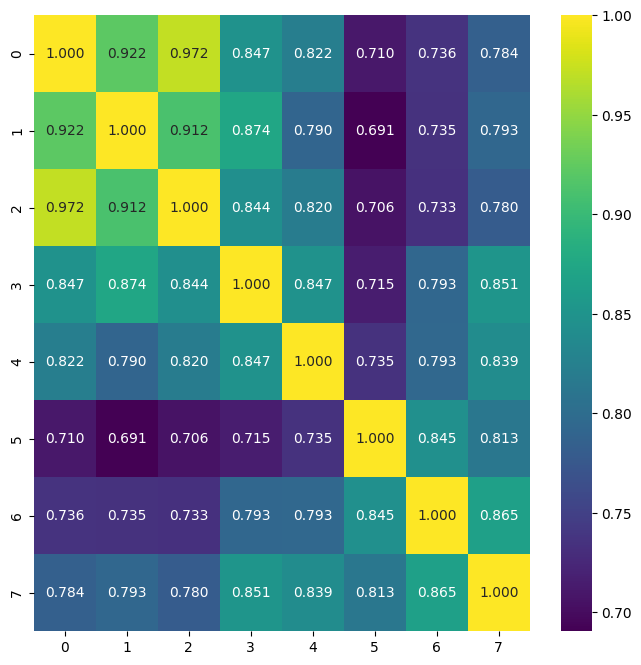

In [411]:
embeddings_similarity_heatmap(openai_embeddings)

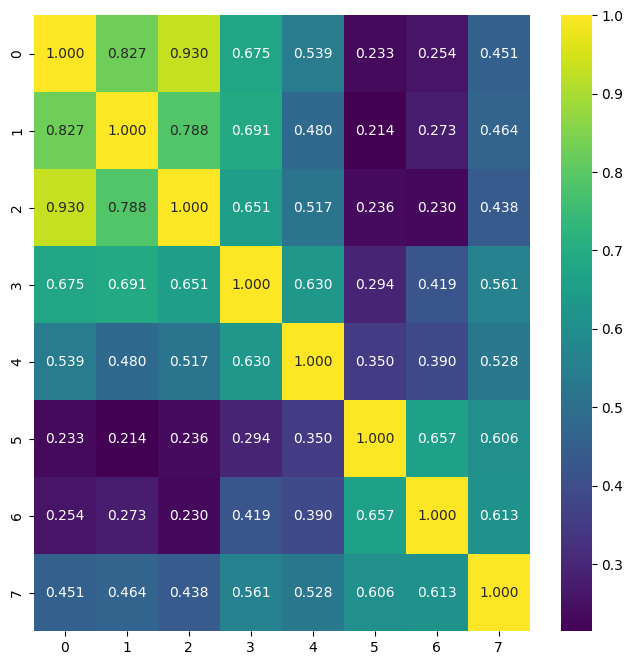

In [412]:
embeddings_similarity_heatmap(cohere_embeddings)

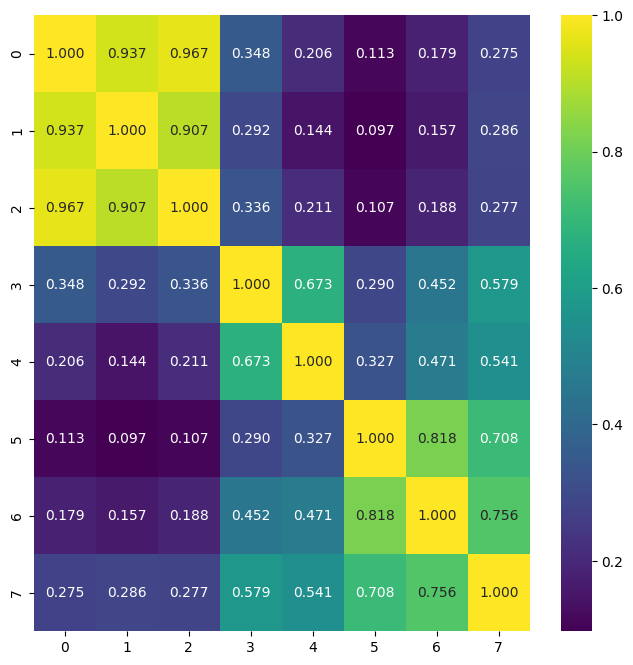

In [413]:
embeddings_similarity_heatmap(sbert_embeddings)

## Multilingual

We use embeddings to capture semantic similarity.  What happens when we look at the same text in several languages.  Will our embeddings reflect the semantic similarity?

Let's examine "Mary had a little lamb" in English, French and Spanish.

In [414]:
mary_english = """Mary had a little lamb,
Little lamb, little lamb,
Mary had a little lamb,
Its fleece was white as snow

Everywhere that Mary went,
Mary went, Mary went,
Everywhere that Mary went
The lamb was sure to go.

It followed her to school one day
School one day, school one day
It followed her to school one day
Which was against the rules.

It made the children laugh and play,
Laugh and play, laugh and play,
It made the children laugh and play
To see the lamb at school

And so the teacher turned it out,
Turned it out, turned it out,
And so the teacher turned it out,
But still it lingered near
"""

mary_french = """Mary avait un petit agneau,
Un petit agneau, un petit agneau,
Mary avait un petit agneau,
C'est toison était blanche comme neige, ouais

Partout, les Mary est allé,
Mary est allé, Mary est allé
Partout, les Mary est allé
Le petit agneau était sûr d'aller, ouais

Il la suivit à l'école un jour
A l'école un jour, à l'école un jour
Il la suivit à l'école un jour
Et enfreint la règle des enseignants.

Il a fait les enfants rient et jouent,
Rire et jouer, rire et jouer,
Il a fait les enfants rient et jouent
Pour voir un agneau à l'école

Et si l'enseignant il s'est avéré,
Il s'est avéré, il s'est avéré,
Et si l'enseignant il s'est avéré,
Mais toujours il resta près de
"""

mary_spanish = """Mary tenía un pequeño cordero,
Pequeño cordero, pequeño cordero
Mary tenía un pequeño cordero
Su lana era blanca como la nieve como la nieve blanca.

A cualquier lado que Mary iba
Mary iba, Mary iba
A cualquier lado que Mary iba
El cordero atrás yendo iba

Un día a la escuela la siguió
A la escuela un día, a la escuela un día
Un día a la escuela la siguió
Y eso estaba en contra de las reglas de la misma.

Hizó a los niños reír y jugar,
Reír y jugar, reír y jugar
Hizó a los niños reír y jugar
De verlo en la escuela estar.

Y entonces la maestra lo alejó,
Lo alejó, lo alejó
Y entonces la maestra lo alejó
Pero sin embargo cerca permanecía.
"""

mary = [mary_english, mary_french, mary_spanish]
mary_openai_embeddings = openai_embeddings_model.embed_documents(mary)
mary_cohere_embeddings = cohere_embeddings_model.embed_documents(mary)
mary_sbert_embeddings = sbert_embeddings_model.embed_documents(mary)

In [415]:
[openai_token_count(string) for string in mary]

[143, 212, 218]

In [416]:
[cohere_token_count(string) for string in mary]

[160, 284, 260]

In [417]:
[sbert_token_count(string) for string in mary]

[145, 205, 168]

The OpenAI embeddings for the three renditions are similar.

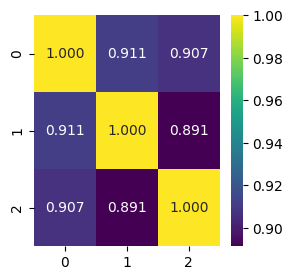

In [418]:
embeddings_similarity_heatmap (mary_openai_embeddings)

The Cohere embeddings are not similar.  That's not surprising since it's an English only model.

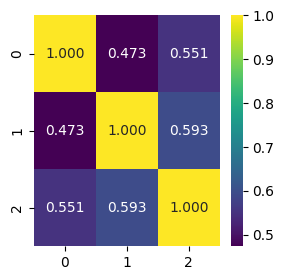

In [419]:
embeddings_similarity_heatmap (mary_cohere_embeddings)

The Setence Transformer embeddings are similar and appear to be closer than the OpenAI embeddings.  This particular mode (`paraphrase-multilingual-mpnet-base-v2`) is a multilingual model.  This performance is not surprising.

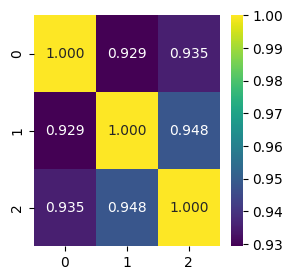

In [420]:
embeddings_similarity_heatmap (mary_sbert_embeddings)

Cohere has a separate embedding model that provides multilingual embedding suport.  Unlike the `embed-english-v2.0` model which has a 512 token maximum, the `embed-multilingual-v2.0` model has a 256 token maximum.  See [Cohere multilingual language models](https://docs.cohere.com/docs/multilingual-language-models)

The Cohere multilingual model is much stronger on this example, but not as strong as the Sentence Transformer model we looked at above.

In [421]:
cohere_multilingual_embeddings_model = CohereEmbeddings(model="embed-multilingual-v2.0", truncate='End')

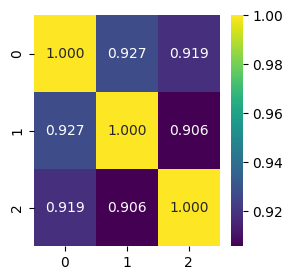

In [422]:
mary_cohere_multilingual_embeddings = cohere_multilingual_embeddings_model.embed_documents(mary)
embeddings_similarity_heatmap (mary_cohere_multilingual_embeddings)

Let's add "Three Blind Mice", in English and compare the OpenAI and Sentence Transformer multilingual embeddings.  Once again, while both seem to work, the Sentence Transformer embeddings seem better for this example.  The similar passagse are more tightly grouped and the outlier is further away.

In [423]:
mice = """Three blind mice, three blind mice
See how they run, see how they run
They all run away from the farmer's wife
Then into a space ship to take a ride
Did you ever see such a sight in your life
As three blind mice?

Three blind mice, three blind mice
Crash on the moon, crash on the moon
The moon was covered in cheese so high
And nobody knew the reason why
Did you ever see such a sight in your life
As three blind mice?

Three blind mice, three blind mice
With full tummies, with full tummies
All of them ate too much cheese that night
With little moon left after every bite
Did you ever see such a sight in your life
As three blind mice?"""

In [424]:
openai_token_count(mice)

159

In [425]:
sbert_token_count(mice)

159

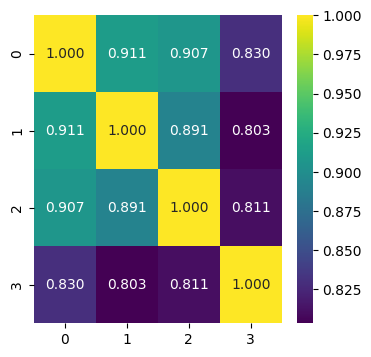

In [426]:
mary_mice_openai_embeddings = openai_embeddings_model.embed_documents(mary + [mice])
embeddings_similarity_heatmap (mary_mice_openai_embeddings)

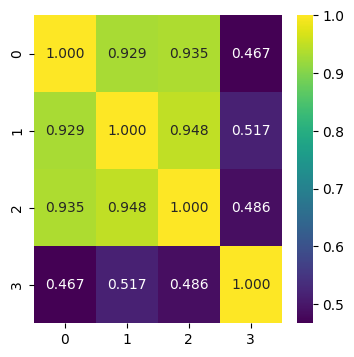

In [427]:
mary_mice_sbert_embeddings = sbert_embeddings_model.embed_documents(mary + [mice])
embeddings_similarity_heatmap (mary_mice_sbert_embeddings)

What happens when we add some music lyrics to the mix?  As we have seen in the prior examples, the OpenAI embeddings don't seem to do as good a job at separating the examples as the Sentence Transformer embeddings do.

In [428]:
bohemian = """I see a little silhouetto of a man
Scaramouche, Scaramouche, will you do the Fandango?
Thunderbolt and lightning, very, very frightening me
(Galileo) Galileo, (Galileo) Galileo, Galileo Figaro, magnifico
But I'm just a poor boy, nobody loves me
He's just a poor boy from a poor family
Spare him his life from this monstrosity"""

In [429]:
openai_token_count(bohemian)

97

In [430]:
sbert_token_count(bohemian)

94

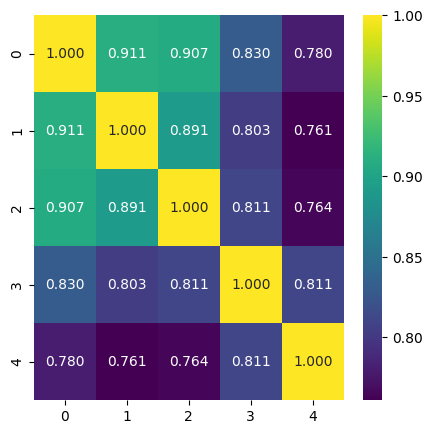

In [431]:
amalgam_openai_embeddings = openai_embeddings_model.embed_documents(mary + [mice, bohemian])
embeddings_similarity_heatmap (amalgam_openai_embeddings)

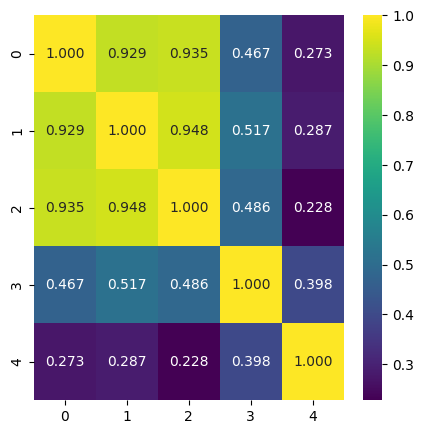

In [432]:
amalgam_sbert_embeddings = sbert_embeddings_model.embed_documents(mary + [mice, bohemian])
embeddings_similarity_heatmap (amalgam_sbert_embeddings)

# Vector Databases

## Introduction

A vector database, also known as a vector search engine or similarity search database, is a type of database that specializes in storing and retrieving high-dimensional vectors efficiently.  The embeddings we have been using are high-dimensional vectors.

In the context of question answering tasks, vector databases can be particularly useful for tasks like semantic search, where you want to find documents or data points that are semantically similar to a given query.

Traditional relational databases are not well-suited for efficiently querying and retrieving semantically similar data. Vector databases, on the other hand, are designed to handle similarity-based searches efficiently.

Vector databases are an essential component of modern natural language processing solutions that are built to apply the generative capabilities of large language models to data collections.  This approach is called retrieval augmented generation or "RAG".

RAG is used in tasks like question answering.  With RAG, a retrieval component first selects a set of relevant documents or passages from a larger corpus, and then a generation component generates the final response based on the selected information. This approach aims to combine the accuracy of retrieval with the flexibility of generation.

We will use Chroma, a simple vector database and explore some of the most important concepts.

## Vector Database Embeddings

The choice of a generative large language model can be decoupled from the selection of the embedding model used in an accompanying vector database.  The models we have been using take a tokenized string as input and not an embedding.  When performing similarity search, you will want to use the same model for generating the embeddings as for turning the query into an embedding for use with the vector database.  Your goal will be to get the string representation of the embeddings returned from the vector database.  LangChain can pass back the results as strings inside LangChain document objects.

Up to this point we have experimented with several different embedding models.  For the remaining exercises, we will use a different embedding model.  We will use `multi-qa-mpnet-base-cos-v1` from the SentenceTransformer collection.  It is based on `microsoft/mpnet-base` and has a maximum token length of `512`.  The embeddings are normalized and cosine-similarity is an appropriate choice for a distance function.

OpenAI trial accounts expire after three months and provide access to `gpt-3.5-turbo` but not `gpt-4`.  Paid OpenAI accounts permit use of `gpt-4` as well and do not expire.  Cohere trial accounts do not expire, but the API rate limiting is more significant than OpenAI trial account rate limiting.

Set the `llm` variable below to reflect the generative model you want to use.  

The results in most of the examples below will vary with your choice.


In [433]:
llm = Cohere(model="command", temperature=0)
#llm = ChatOpenAI(model="gpt-3.5-turbo", temperature=0)
#llm = ChatOpenAI(model="gpt-4", temperature=0)

In [434]:
st_model_name = 'multi-qa-mpnet-base-cos-v1'
st_embeddings_model = HuggingFaceEmbeddings(model_name=st_model_name)
st_tokenizer = AutoTokenizer.from_pretrained(f"sentence-transformers/{st_model_name}")

embeddings_model=st_embeddings_model

In [435]:
!pip install --quiet chromadb
from langchain.vectorstores import Chroma

## Document Chunking

Document chunking, also known as text segmentation or document splitting, refers to the process of breaking down large documents or pieces of text into smaller, manageable segments before feeding them to large language models. There are several reasons why chunking is important when working with these models.

Chunking documents when working with large language models is essential to overcome input limitations, improve performance, manage costs, ensure complete responses, maintain contextual coherence, and guide the model's attention effectively. It allows you to make the most out of these powerful models when dealing with lengthy or complex text documents.

In the following code cells, we will download several corporate privay policies from the web.  We will use document loaders specific to `pdf` files or `urls` as the case may be.

We the use LangChain's `RecursiveCharacterTextSplitter` to chunk each document.  See the relevant [LangChain documentation](https://python.langchain.com/docs/modules/data_connection/document_transformers/text_splitters/recursive_text_splitter).

We add a piece of metadata that identifies the relevant organization for each chunk.  We discuss this in greater detail below.

In [436]:
!pip install --quiet pypdf unstructured

import textwrap
from langchain.document_loaders import PyPDFLoader, UnstructuredURLLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter

In [437]:
import pandas as pd

policy_data = [
    ("Apple", "Privacy Policy", "https://www.apple.com/legal/privacy/pdfs/apple-privacy-policy-en-ww.pdf"),
    ("Google", "Privacy Policy", "https://static.googleusercontent.com/media/www.google.com/en//intl/en/policies/privacy/google_privacy_policy_en.pdf"),
    ("Meta", "Privacy Policy", "https://about.fb.com/wp-content/uploads/2022/07/Privacy-Within-Metas-Integrity-Systems.pdf"),
    ("TikTok", "Privacy Policy", "https://www.tiktok.com/legal/page/us/privacy-policy/en"),
    ("Threads", "Privacy Policy", "https://terms.threads.com/privacy-policy")
]

columns = ['organization', 'title', 'url']

policy_df = pd.DataFrame(policy_data, columns=columns)

In [438]:
def get_chunks (url, organization, title, chunk_size=512, chunk_overlap=50):

    """
    This function takes a url to an organization's web page, organization name,
    and document title and returns chunks constructed from the target url.
    The function adds the url, the organization name and the document title
    as metadata to the chunks.

    Parameters:
    url (string): Target page.
    organization (string): Organization name.
    title: Document title.
    chunk_size (int, optional): Chunk size, default is 1000 characters.
    chunk_overlap (int, optional): Chunk overlap, default is 10 characters.

    Returns:
    list of chunks
    """

    # Use PyPDFLoader for pdf targets, otherwise UnstructuredURLLoader
    if os.path.splitext(url)[1] == ".pdf":
      loader = PyPDFLoader(url)
    else:
      loader = UnstructuredURLLoader(urls=[url])

    # Load the documents and add organization metadata field.
    # Increment page count metadata by one so it's not zero-based.

    documents = loader.load()
    for document in documents:
      metadata = document.metadata
      metadata['url'] = url
      metadata['organization'] = organization
      metadata['title'] = title
      if metadata.get('page', None) is not None:
        metadata['page'] += 1

    text_splitter = RecursiveCharacterTextSplitter(chunk_size=chunk_size,
                                                   chunk_overlap=chunk_overlap)

    return text_splitter.split_documents(documents)

def explore_documents (documents):
  block_indent = "   "
  metadata=documents[0].metadata
  content=documents[0].page_content[:200] + ". . ."
  print(f"{metadata['organization']} {metadata['title']} {len(documents)} chunks")
  print("Truncated First chunk:")
  print(textwrap.fill(content,
                      initial_indent=block_indent,
                      subsequent_indent=block_indent,
                      replace_whitespace=True))
  print()

In [439]:
chunks=[]

for row in policy_df.itertuples(index=False):
  policy_chunks = get_chunks(row.url, row.organization, row.title)
  explore_documents(policy_chunks)
  chunks += policy_chunks

Apple Privacy Policy 60 chunks
Truncated First chunk:
   Apple Privacy Policy Apple’s Privacy Policy describes how Apple
   collects, uses, and shares your personal data. Updated December 22,
   2022 In addition to this Privacy Policy, we provide data and
   privacy. . .

Google Privacy Policy 58 chunks
Truncated First chunk:
   Privacy Policy Last modified: December 18, 2017 ( view archived
   versions ) (The hyperlinked examples are available at the end of
   this document.) There are many different ways you can use our
   services . . .

Meta Privacy Policy 139 chunks
Truncated First chunk:
   July 2022   Privacy within Meta’s   Integrity Systems   Why user
   rights are at the center   of our safety and security approach. . .

TikTok Privacy Policy 81 chunks
Truncated First chunk:
   U.S.  Privacy Policy  Last updated: May 22, 2023. . .

Threads Privacy Policy 58 chunks
Truncated First chunk:
   🤝Legal  Privacy Policy  Effective date: April 17, 2023  At Threads,
   we take your pri

## Create Vector Database from Chunked Documents

We will use the `get_chunks` helper function we used above to assemble a list of all the chunks and then pass that list to a function that instantiates a vector database from those chunks and an embedding model.

In [440]:
# There are 396 chunks in all.

len(chunks)

396

In [441]:
# Let's take a look at a couple of chunks.

chunks[22]

Document(page_content='your consent or the fact that the processing is necessary to fulfill a contract with you, protect your vital interests or those of other persons, or to comply', metadata={'source': '/tmp/tmp9x95tma8/tmp.pdf', 'page': 4, 'url': 'https://www.apple.com/legal/privacy/pdfs/apple-privacy-policy-en-ww.pdf', 'organization': 'Apple', 'title': 'Privacy Policy'})

In [443]:
chunks[160]

Document(page_content='would run into accuracy and fairness issues.  34  It  would likely exhibit unacceptable biases and not \n be able to account for the nuance of discrimination and hate in every country around the world. \n This is because there is no singular profile of a hate speaker or recipient. Hate speech varies from \n country to country or even group to group.  35  However,  we have found success in predicting \n content that is likely hate speech by comparing previously-confirmed hate speech to new', metadata={'source': '/tmp/tmpq37t6wut/tmp.pdf', 'page': 10, 'url': 'https://about.fb.com/wp-content/uploads/2022/07/Privacy-Within-Metas-Integrity-Systems.pdf', 'organization': 'Meta', 'title': 'Privacy Policy'})

In [ ]:
%%time
vectordb = Chroma.from_documents(documents=chunks, embedding=embeddings_model)
assert vectordb._collection.count() == len(chunks)

## Query the Vector Database

A similarity search that returns the four vectors closest to the query by default.

In [ ]:
query = "Does Apple sell my personal data?"
results = vectordb.similarity_search(query)
[result.metadata['organization'] for result in results]

['Apple', 'Apple', 'Apple', 'Apple']

Examine the first result in the list.  It looks to be responsive to the question.

In [ ]:
print(textwrap.fill(results[0].page_content))

are available at apple.com/legal/privacy/data. When you create an
Apple ID, apply for commercial credit, purchase and/or activate a
product or device, download a software update, register for a class at
an Apple Store, connect to our services, contact us (including by
social media), participate in an online survey, or otherwise interact
with Apple, we may collect a variety of information, including:
•Account Information. Your Apple ID and related account details,
including email address, devices


Increase the number of results to 10.

In [ ]:
query = "Does Apple sell my personal data?"
results = vectordb.similarity_search(query, k=10)
[result.metadata['organization'] for result in results]

['Apple',
 'Apple',
 'Apple',
 'Apple',
 'Apple',
 'Apple',
 'Apple',
 'Apple',
 'Apple',
 'Apple']

When we ask about Apple's use of cookies, there's a problem.  We get responses that don't relate to Apple.

Can you imagine why?

In [ ]:
query = "Does Apple use cookies?"
results = vectordb.similarity_search (query, k=10)
[result.metadata['organization'] for result in results]

['Apple',
 'Apple',
 'Apple',
 'TikTok',
 'Apple',
 'Threads',
 'Threads',
 'TikTok',
 'Apple',
 'TikTok']

The first result looks good.  It talks about Apple and the fact that Apple uses cookies.

In [ ]:
print(textwrap.fill(results[0].page_content))

that Apple not use cookies, we provide you with the means to disable
their use. If you want to disable cookies and you’re using the Safari
web browser, choose “Block all cookies” in Safari’s privacy settings.
If you are using a different browser, check with your provider to find
out how to disable cookies. Certain features of the Apple website may
not be available if all cookies are disabled. In addition to cookies,
Apple uses other technologies that help us achieve similar objectives.
In some email


Now lets look at any other responses.  Did we ask for too many results?  Are there chunks that talk about cookies but don't mention the company?

In [ ]:
for result in results:
  if result.metadata['organization'] != "Apple":
    print("Organization: ", result.metadata['organization'])
    print(textwrap.fill(result.page_content))
    print()

Organization:  TikTok
Cookies. We and our service providers and business partners use
cookies and other similar technologies (e.g., web beacons, flash
cookies, etc.) (“Cookies”) to automatically collect information,
measure and analyze how you use the Platform, including which pages
you view most often and how you interact with content, enhance your
experience using the Platform, improve the Platform, provide you with
advertising, and measure the effectiveness of advertisements and other
content. We and our partners also use

Organization:  Threads
Cookies are small pieces of data– usually text files – placed on your
computer, tablet, phone or similar device when you use that device to
access Threads. We may also supplement the information we collect from
you with information received from third parties, including third
parties that have placed their own Cookies on your device(s). Please
note that because of our use of Cookies, Threads does not support "Do
Not Track" requests sent from

When we processed the source documents and split them into chunks, we added the name of the organization for the policy as metadata.  We can use that metadata as a filter.  In our example below, the filter is very simple, we merely indicate that the organization field needs to be `Apple`.  When we add that parameter, the results are limited to Apple embeddings.

In [ ]:
results = vectordb.similarity_search (query, filter = {'organization':'Apple'}, k=10)
[result.metadata['organization'] for result in results]

['Apple',
 'Apple',
 'Apple',
 'Apple',
 'Apple',
 'Apple',
 'Apple',
 'Apple',
 'Apple',
 'Apple']

Our next query only references "the company" and not any specific company.  The results relate to several of the companies.

In [ ]:
query = "Does the company sell private data?"
results = vectordb.similarity_search (query, k=10)
[result.metadata['organization'] for result in results]

['Apple',
 'Apple',
 'TikTok',
 'Threads',
 'Google',
 'TikTok',
 'Apple',
 'Apple',
 'Apple',
 'TikTok']

We can use the filter to indicate that we care about Google only.

In [ ]:
query = "Does the company sell private data?"
results = vectordb.similarity_search (query, filter = {'organization':'Google'}, k=10)
[result.metadata['organization'] for result in results]

['Google',
 'Google',
 'Google',
 'Google',
 'Google',
 'Google',
 'Google',
 'Google',
 'Google',
 'Google']

In [ ]:
print(textwrap.fill(results[0].page_content))

by law. We may share  non-personally identifiable information
publicly and with our partners – like publishers, advertisers or
connected sites. For example, we may share information publicly to
show trends  about the general use of our services. If Google is
involved in a merger, acquisition or asset sale, we will continue to
ensure the confidentiality of any personal information and give
affected users notice before personal information is transferred or
becomes subject to a different privacy policy.


# Answering Questions With Retrieval Augmented Generation

Now that we have some familiarity with vector databases, lets use ours, together with a large language model, to answer questions about the five privacy policies we have been working with.  We will continue to rely on the LangChain framework.

## Prompting a Model

Before we introduce working with the vector database, let's experiment with some simple model prompts.  We will pass a string to Cohere's `command` model, which is its default generative model, and see how it responds.  We will do the same thing with OpenAI's `chatgpt-3.5`.

The responses are based on information the model was trained on.  We don't know if it they are accurate.  Sources are not presented.  The Cohere response for Threads doesn't seem to relate to the Threads social media platform and the OpenAI model isn't able to fine Threads information.

In [ ]:
from langchain.schema import HumanMessage

cohere_llm = Cohere (model="command", temperature=0)
openai_llm = ChatOpenAI (model_name='gpt-3.5-turbo', temperature=0)

In [ ]:
query = "Does Apple sell my personal data?"
result = cohere_llm(query)
print(textwrap.fill(result.strip()))

Apple has a strong commitment to protecting the privacy of its
customers. The company does not sell personal data to third parties.
However, it does collect and use data to provide services and improve
products.  For example, Apple collects data about how people use their
devices, such as which apps are used and how often. This data is used
to improve the user experience and develop new features.  Apple also
collects data about customers' purchasing habits, which is used to
improve marketing and develop new products.  In addition, Apple
collects data about customers' location, which is used to provide
location-based services and improve maps.  Apple's commitment to
privacy is a key selling point for many customers. The company's
privacy policies are designed to protect customers' personal data and
ensure that it is used only for legitimate purposes.


In [ ]:
query = "Does Threads sell my personal data?"
result = cohere_llm(query)
print(textwrap.fill(result.strip()))

Threads does not sell your personal data. We are committed to
protecting your privacy and will never share your personal information
with third parties without your permission.  We may collect and use
your personal information for the following purposes:  - To provide
you with the services you request - To improve our services and
products - To communicate with you about our services and products -
To protect our rights and property - To comply with legal obligations
We will never share your personal information with third parties
without your permission, except as required by law. We will never sell
your personal information to third parties.  If you have any questions
or concerns about how we use your personal information, please contact
us at support@threadscanada.com.


In [ ]:
messages = [HumanMessage(content="Does Apple sell my personal data?")]
print(textwrap.fill(openai_llm(messages).content))

Apple has a strong commitment to privacy and has stated that it does
not sell personal data to third parties. Apple's business model
primarily relies on selling hardware, software, and services rather
than monetizing user data. However, it is important to note that Apple
does collect and use certain user data for various purposes, such as
improving its products and services, but it is typically anonymized
and aggregated to protect user privacy.


In [ ]:
messages = [HumanMessage(content="Does Threads sell my personal data?")]
print(textwrap.fill(openai_llm(messages).content))

As an AI language model, I don't have access to specific company
policies or practices. However, it is important to note that I am
developed by OpenAI and designed to respect user privacy and
confidentiality. My primary function is to provide information and
answer questions to the best of my knowledge and abilities. If you
have concerns about data privacy, it is recommended to review the
privacy policy of Threads or contact the company directly for more
information.


## LangChain PromptTemplate

A prompt template is a reproducible way to generate prompts. It's essentially a text string that can take in a set of parameters from the end user and generate a prompt accordingly.  Let's shift to LangChain chains by using the simplest of templates.  In these examples, we use the large language model you selected above.  Remember, the model is generating responses based on its training data.

In [ ]:
from langchain import PromptTemplate, LLMChain

In [ ]:
template = """Question: {question} Answer:"""
prompt = PromptTemplate(
    template=template,
    input_variables=['question']
)

chain = LLMChain(prompt=prompt, llm=llm)

Let's inspect the prompt included inside the chain.

In [ ]:
chain.prompt

PromptTemplate(input_variables=['question'], output_parser=None, partial_variables={}, template='Question: {question} Answer:', template_format='f-string', validate_template=True)

In [ ]:
query = "Does Apple sell my personal data?"
print(textwrap.fill(chain.run(query)).strip())

No, Apple does not sell your personal data. Apple has a strong
commitment to privacy and has implemented various measures to protect
user data.


In [ ]:
query = "Does Threads sell my personal data?"
print(textwrap.fill(chain.run(query)).strip())

No, Threads does not sell your personal data.


## LangChain RetrievalQA Chain

Now we introduce our vector database and the LangChain Retrieval QA chain, a chain for question answering against a database of information.  We will also supply our own prompt. It would be reassuring if sources were identified.

In [ ]:
from langchain.chains import RetrievalQA

In [ ]:
template = """Use the following pieces of context to answer the question at the end.
Your answer should be as concise as possible and ideally not more than one sentence.
If you don't know the answer, just say that you don't know.

{context}

Question: {question}

Answer:"""

prompt = PromptTemplate(template=template,
                        input_variables=["context", "question"]
                        )

chain = RetrievalQA.from_chain_type(
    llm,
    retriever=vectordb.as_retriever(),
    chain_type_kwargs={"prompt": prompt}
)

Before we call the chain, let's inspect our template and the retriever it includes.

In [ ]:
print(chain.combine_documents_chain.llm_chain.prompt.template)

Use the following pieces of context to answer the question at the end.
Your answer should be as concise as possible and ideally not more than one sentence.
If you don't know the answer, just say that you don't know.

{context}

Question: {question}

Answer:


In [ ]:
chain.retriever

VectorStoreRetriever(tags=['Chroma', 'HuggingFaceEmbeddings'], metadata=None, vectorstore=<langchain.vectorstores.chroma.Chroma object at 0x7c64cc413d90>, search_type='similarity', search_kwargs={})

In [ ]:
query = "Does Apple sell my personal data?"
result = chain.run(query)
print(textwrap.fill(result.strip()))

The text does not provide information on whether Apple sells personal
data.


In [ ]:
query = "Does Threads sell my personal data?"
result = chain.run(query)
print(textwrap.fill(result.strip()))

The text does not provide information on whether Threads sells your
personal data.


Let's use the same prompt and get source documents too.

In [ ]:
chain = RetrievalQA.from_chain_type(
    llm=llm,
    retriever=vectordb.as_retriever(),
    chain_type_kwargs={"prompt": prompt},
    return_source_documents=True
    )

In [ ]:
query = "Does Apple sell my personal data?"
result = chain({"query": query})

Now, instead of returning a string, the result is a dictionary with three keys, `query`, `result` and `source_documents`.

In [ ]:
result.keys()

dict_keys(['query', 'result', 'source_documents'])

In [ ]:
print(textwrap.fill(result['result'].strip()))

The text does not provide information on whether Apple sells personal
data.


Let's examine the `organization` field for the source documents from that result.

In [ ]:
[source.metadata['organization'] for source in result['source_documents']]

['Apple', 'Apple', 'Apple', 'Apple']

Let's ask a general question and then say we only care about Apple and Microsoft.  Notice that the source documents don't include Microsoft and a TikTok document appears as a source.  We need to make use of the metadata we included.

In [ ]:
query = "Do companies use cookies?  I only care about Apple and Microsoft."
result = chain({"query": query})

In [ ]:
print(textwrap.fill(result['result'].strip()))

Yes, both Apple and Microsoft use cookies.


In [ ]:
[source.metadata['organization'] for source in result['source_documents']]

['Apple', 'Apple', 'TikTok', 'Apple']

Self-querying retriever.

A self-querying retriever is one that, as the name suggests, has the ability to query itself. Specifically, given any natural language query, the retriever uses a query-constructing LLM chain to write a structured query and then applies that structured query to it's underlying VectorStore. This allows the retriever to not only use the user-input query for semantic similarity comparison with the contents of stored documented, but to also extract filters from the user query on the metadata of stored documents and to execute those filters.

The following code does not yet work with Cohere.


In [ ]:
!pip install --quiet lark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.9/108.9 kB 1.8 MB/s eta 0:00:00


In [ ]:
prompt

PromptTemplate(input_variables=['context', 'question'], output_parser=None, partial_variables={}, template="Use the following pieces of context to answer the question at the end.\nYour answer should be as concise as possible and ideally not more than one sentence.\nIf you don't know the answer, just say that you don't know.\n\n{context}\n\nQuestion: {question}\n\nAnswer:", template_format='f-string', validate_template=True)

In [ ]:
from langchain.retrievers.self_query.base import SelfQueryRetriever
from langchain.chains.query_constructor.base import AttributeInfo

metadata_field_info=[
    AttributeInfo(
        name="organization",
        description="The organization, company, entity or institution that the document relates to",
        type="string or list[string]",
    ),
    AttributeInfo(
        name="title",
        description="The title of the document",
        type="string",
    ),
    AttributeInfo(
        name="url",
        description="The url for the document",
        type="string",
    ),
]
document_content_description = "A policy"
retriever = SelfQueryRetriever.from_llm(llm, vectordb, document_content_description, metadata_field_info, verbose=False, enable_limit=True)

template = """Use the following pieces of context to answer the question at the end.
If you don't know the answer, just say that you don't know.

{context}

Question: {question}

Answer:"""

prompt = PromptTemplate(template=template, input_variables=["context", "question"])

chain = RetrievalQA.from_chain_type(
    llm=llm,
    retriever=retriever,
    chain_type_kwargs={"prompt": prompt},
    return_source_documents=True
    )

In [ ]:
documents = retriever.get_relevant_documents("Does Threads use cookies?")
result = chain({"query": "Does the company named Threads use cookies?"})
result

/usr/local/lib/python3.10/dist-packages/langchain/chains/llm.py:279: UserWarning: The predict_and_parse method is deprecated, instead pass an output parser directly to LLMChain.
  warnings.warn(


OutputParserException: ignored

In [ ]:
documents = retriever.get_relevant_documents("Does Google use cookies?")

query='use cookies' filter=Comparison(comparator=<Comparator.EQ: 'eq'>, attribute='organization', value='Google') limit=None


In [ ]:
documents = retriever.get_relevant_documents("Do Apple or Microsoft use cookies?")

query='cookies' filter=Operation(operator=<Operator.OR: 'or'>, arguments=[Comparison(comparator=<Comparator.EQ: 'eq'>, attribute='organization', value='Apple'), Comparison(comparator=<Comparator.EQ: 'eq'>, attribute='organization', value='Microsoft')]) limit=None


In [ ]:
documents = retriever.get_relevant_documents("Which companies use cookies?")

query='cookies' filter=None limit=None


In [ ]:
retriever.get_relevant_documents("Tell me two companies that use cookies?")

query='cookies' filter=None limit=2


[Document(page_content='Cookies. We and our service providers and business partners use cookies and other similar technologies (e.g., web beacons, flash cookies, etc.) (“Cookies”) to automatically collect information, measure and analyze how you use the Platform, including which pages you view most often and how you interact with content, enhance your experience using the Platform, improve the Platform, provide you with advertising, and measure the effectiveness of advertisements and other content. We and our partners also use', metadata={'organization': 'TikTok', 'source': 'https://www.tiktok.com/legal/page/us/privacy-policy/en', 'title': 'Privacy Policy', 'url': 'https://www.tiktok.com/legal/page/us/privacy-policy/en'}),
 Document(page_content='Cookies are small pieces of data– usually text files – placed on your computer, tablet, phone or similar device when you use that device to access Threads. We may also supplement the information we collect from you with information received fr